In [1]:
import Pkg 
Pkg.status()

Status `C:\Users\lingy\Documents\MRAC_LQR\Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [a6e380b2] ControlSystems v1.11.2
  [91a5bcdd] Plots v1.40.9


In [3]:
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots, ControlSystems

In [39]:
# 系统参数
J = 7.23e-4    # 转动惯量 (kg·m²)
dt = 0.001   # 采样时间 (s)
sim_time = 2.0  # 仿真总时长
θ = 60.0

60.0

In [40]:
# 连续时间状态空间模型
A = [0.0 1.0;
     0.0 0.0]
B = [0.0;
     1/J]
C = [1.0 0.0;   # 观测角度
     0.0 1.0]   # 观测角速度
D = [0.0;
     0.0]

2-element Vector{Float64}:
 0.0
 0.0

In [41]:
sys_cont = ss(A, B, C, D)  # 创建连续系统

# 离散化系统（零阶保持）
sys_dis = c2d(sys_cont, dt, :zoh)

StateSpace{Discrete{Float64}, Float64}
A = 
 1.0  0.0010000000000000002
 0.0  1.0
B = 
 0.0006915629322268328
 1.3831258644536655
C = 
 1.0  0.0
 0.0  1.0
D = 
 0.0
 0.0

Sample Time: 0.001 (seconds)
Discrete-time state-space model

In [42]:
# LQR权重矩阵
Q = diagm([50000.0, 100.0])  # 状态权重 [角度, 角速度]
R = diagm([0.1])               # 控制输入权重

1×1 Matrix{Float64}:
 0.1

In [43]:
# 设计离散LQR控制器
K = dlqr(sys_dis.A, sys_dis.B, Q, R)

1×2 Matrix{Float64}:
 15.9797  0.730621

In [44]:
# 闭环系统矩阵
A_cl = sys_dis.A - sys_dis.B*K

2×2 Matrix{Float64}:
   0.988949   0.00049473
 -22.1019    -0.0105402

In [45]:
# 仿真参数
t_steps = 0:dt:sim_time
N = length(t_steps)
x0 = [0.0, 0.0]  # 初始状态
xd = [θ*pi/180.0;0.0] #目标状态

@show uff = (pinv(I-sys_dis.A)*sys_dis.B)\xd

# 初始化存储数组
x_hist = zeros(2, N)
x_hist_ff = zeros(2, N)
u_hist = zeros(N-1)
u_hist_ff = zeros(N-1)
ref_hist = zeros(2, N)
x_hist[:, 1] = x0
x_hist_ff[:, 1] = x0
ref_hist[:, 1] = xd

uff = (pinv(I - sys_dis.A) * sys_dis.B) \ xd = [-0.723]


2-element Vector{Float64}:
 1.0471975511965976
 0.5

In [46]:
# 运行闭环仿真
for i in 1:N-1
    Δx1 = x_hist[:, i] - ref_hist[:, i]
    Δx2 = x_hist_ff[:, i] - ref_hist[:, i]
    u1 = -K * Δx1
    u2 = uff - K * Δx2
    x_hist[:, i+1] = sys_dis.A * x_hist[:, i] + sys_dis.B * u1
    x_hist_ff[:, i+1] = sys_dis.A * x_hist_ff[:, i] + sys_dis.B * u2
    ref_hist[:, i+1] = ref_hist[:, i]
    u_hist[i] = u1[1]
    u_hist_ff[i] = u2[1]
end

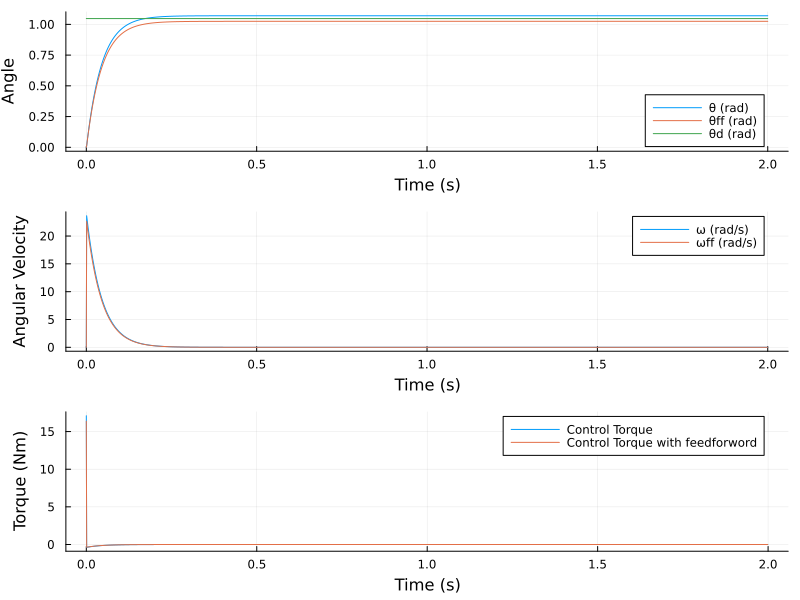

In [47]:
# 绘制结果
p1 = plot(t_steps, x_hist[1, :], label="θ (rad)", xlabel="Time (s)", ylabel="Angle")
plot!(t_steps, x_hist_ff[1, :], label="θff (rad)")
plot!(t_steps, ref_hist[1, :], label="θd (rad)")
p2 = plot(t_steps, x_hist[2, :], label="ω (rad/s)", xlabel="Time (s)", ylabel="Angular Velocity")
plot!(t_steps, x_hist_ff[2, :], label="ωff (rad/s)")
p3 = plot(t_steps[1:end-1], u_hist, label="Control Torque", xlabel="Time (s)", ylabel="Torque (Nm)")
plot!(t_steps[1:end-1], u_hist_ff, label="Control Torque with feedforword")
plot(p1, p2, p3, layout=(3,1), size=(800,600))